In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import zscore
import os
from scipy.stats import ranksums
from statsmodels.stats.multitest import fdrcorrection
working_dir = "/Users/nkarisan/PycharmProjects/BTC_Cell_Line_Atlas_Manuscript"
os.chdir(working_dir)

import scripts.io_library as io_library
io_library.input_dir = 'input_data/'
io_library.output_dir = 'Figure5/output_fig5/'

from scripts.io_library import MyLib
from scripts.clustering_utils import Clustering
from scripts.visualization import MyVisualization
from scripts.utils import Utils
from scripts.invoking_R_functions import MyRFunctions

In [2]:
import matplotlib
seed = 2023
random.seed(seed)
np.random.seed(seed)

matplotlib.use("nbagg")


%matplotlib inline
%config InlineBackend.figure_format = "retina"


%load_ext autoreload
%autoreload 2

# Initialization

## Files and constants

In [3]:
rna_all_file = 'Main_Data/RNA/rna_cell_lines.csv'
upset_file = 'cell_lines_master_upset_2025-2-24.csv'
maroon_color = '#A00000'
base_color = '#d4d4d4'

## Load the data

In [4]:
exp_df = MyLib.load_csv(rna_all_file, index_col=0)
exp_df = exp_df.T # samples are the rows

raw_upset_df = MyLib.load_csv(upset_file)
raw_upset_df.set_index('Cell_line', inplace=True, drop=True)
upset_df = raw_upset_df[raw_upset_df['RNA']==1]

upset_df = upset_df[["Subtype"]]
upset_df = upset_df.loc[exp_df.index, :]

top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
upset_mut_df = pd.concat([upset_df, top_mut_df.loc[upset_df.index, :]], axis=1)
upset_mut_df = upset_mut_df[["FGFR2$","BAP1$", "IDH1/2$","BRAF$","SMAD4$", "KRAS$", "TP53$" ]]
upset_df = pd.concat([upset_df, upset_mut_df], axis=1)
rna_reordered_upset_df = None

input_data/Main_Data/RNA/rna_cell_lines.csv  is loaded, shape:  (17649, 79)

input_data/cell_lines_master_upset_2025-2-24.csv  is loaded, shape:  (87, 12)

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)



In [5]:
upset_df

,Subtype,FGFR2$,BAP1$,IDH1/2$,BRAF$,SMAD4$,KRAS$,TP53$
CCLP1,ICC,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE
CCSW1,ICC,NaN,NaN,NaN,NaN,Het_loss,NaN,MISSENSE
AOVC1,AC,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE
ECC3,ECC,NaN,NaN,NaN,NaN,SPLICE_SITE,NaN,MISSENSE
EGI1,ECC,NaN,NaN,NaN,NaN,NaN,MISSENSE,MISSENSE
...,...,...,...,...,...,...,...,...
TFK1,ECC,NaN,NONSENSE,NaN,NaN,NaN,NaN,NONSENSE
TGBC1TKB,GBC,NaN,NaN,NaN,NaN,NaN,NaN,FRAME_SHIFT_INS
TGBC52TKB,AC,NaN,NaN,NaN,NaN,NaN,MISSENSE,NaN
TKKK,ICC,NaN,NaN,NaN,NaN,NaN,NaN,NONSENSE


In [6]:
print(len(upset_df))
upset_df[upset_df['Subtype']=='HCC'].shape

79


(23, 8)

## Fold change and Correlation
The DepMap expression values are log2(TPM+1) transformed, and we apply median normalization of each gene across all samples.

In [7]:
fold_exp_df = exp_df.apply(lambda x:x-x.median())
corr_fold_exp_df = pd.DataFrame(np.corrcoef(fold_exp_df.values), columns=fold_exp_df.index, index=fold_exp_df.index)

# Clustering


File  Figure5/output_fig5/all_R1_features_Up.csv saved, shape: (2831, 4)

File  Figure5/output_fig5/R1_features_Up.csv saved, shape: (50, 3)

File  Figure5/output_fig5/all_R2_features_Up.csv saved, shape: (2244, 4)

File  Figure5/output_fig5/R2_features_Up.csv saved, shape: (50, 3)

File  Figure5/output_fig5/all_R3_features_Up.csv saved, shape: (2387, 4)

File  Figure5/output_fig5/R3_features_Up.csv saved, shape: (50, 3)

File  Figure5/output_fig5/all_R4_features_Up.csv saved, shape: (1471, 4)

File  Figure5/output_fig5/R4_features_Up.csv saved, shape: (50, 3)

File  Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv saved, shape: (79, 2)


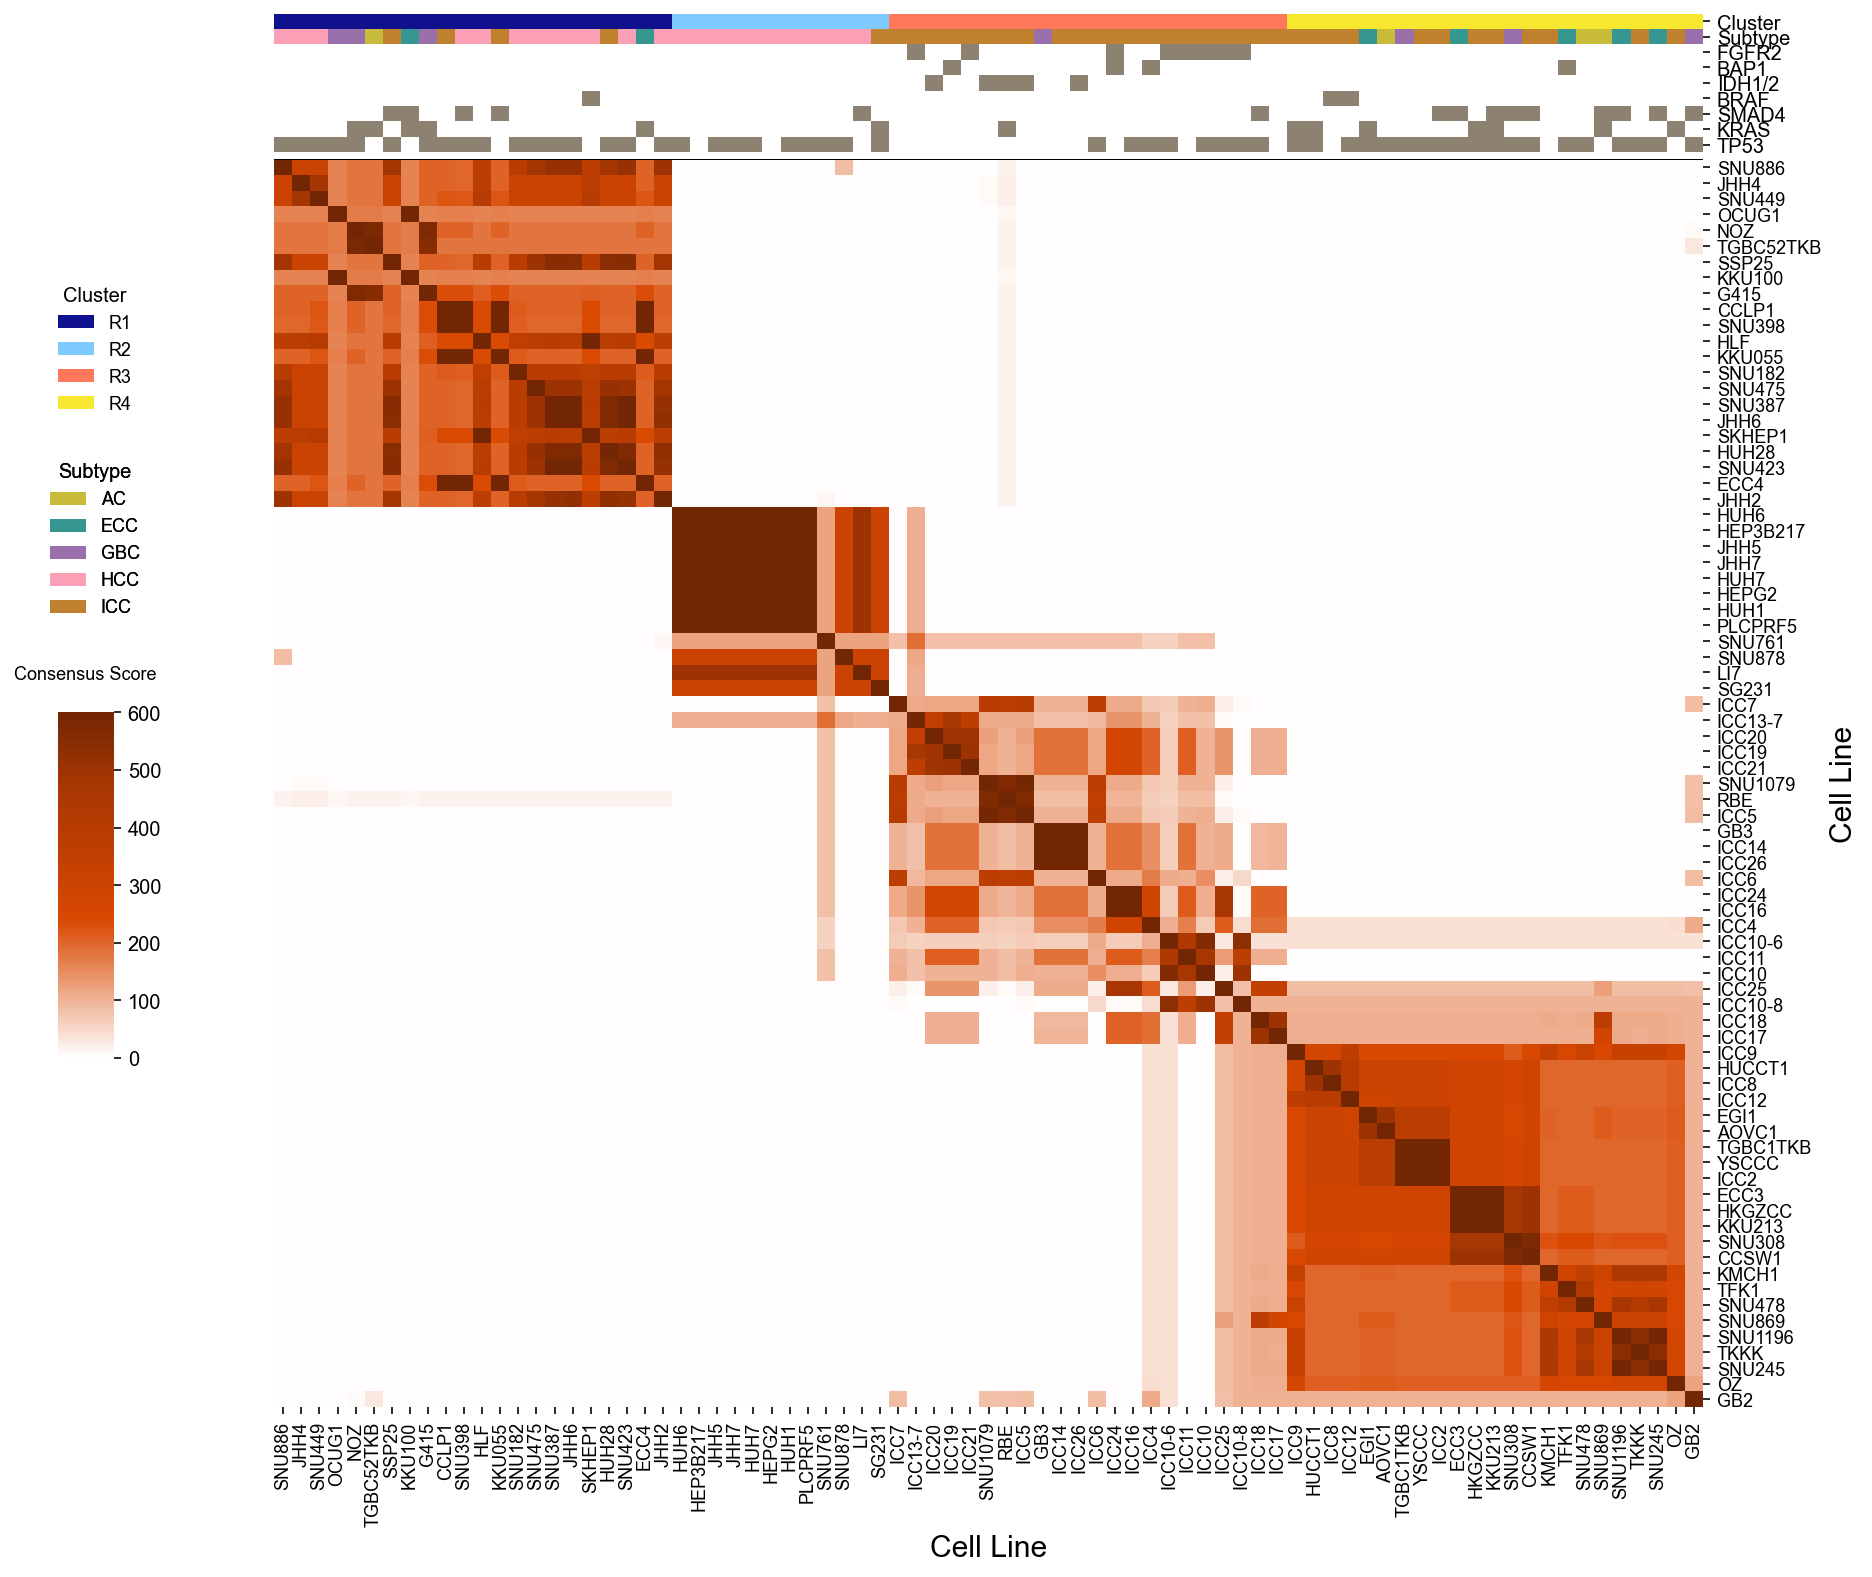

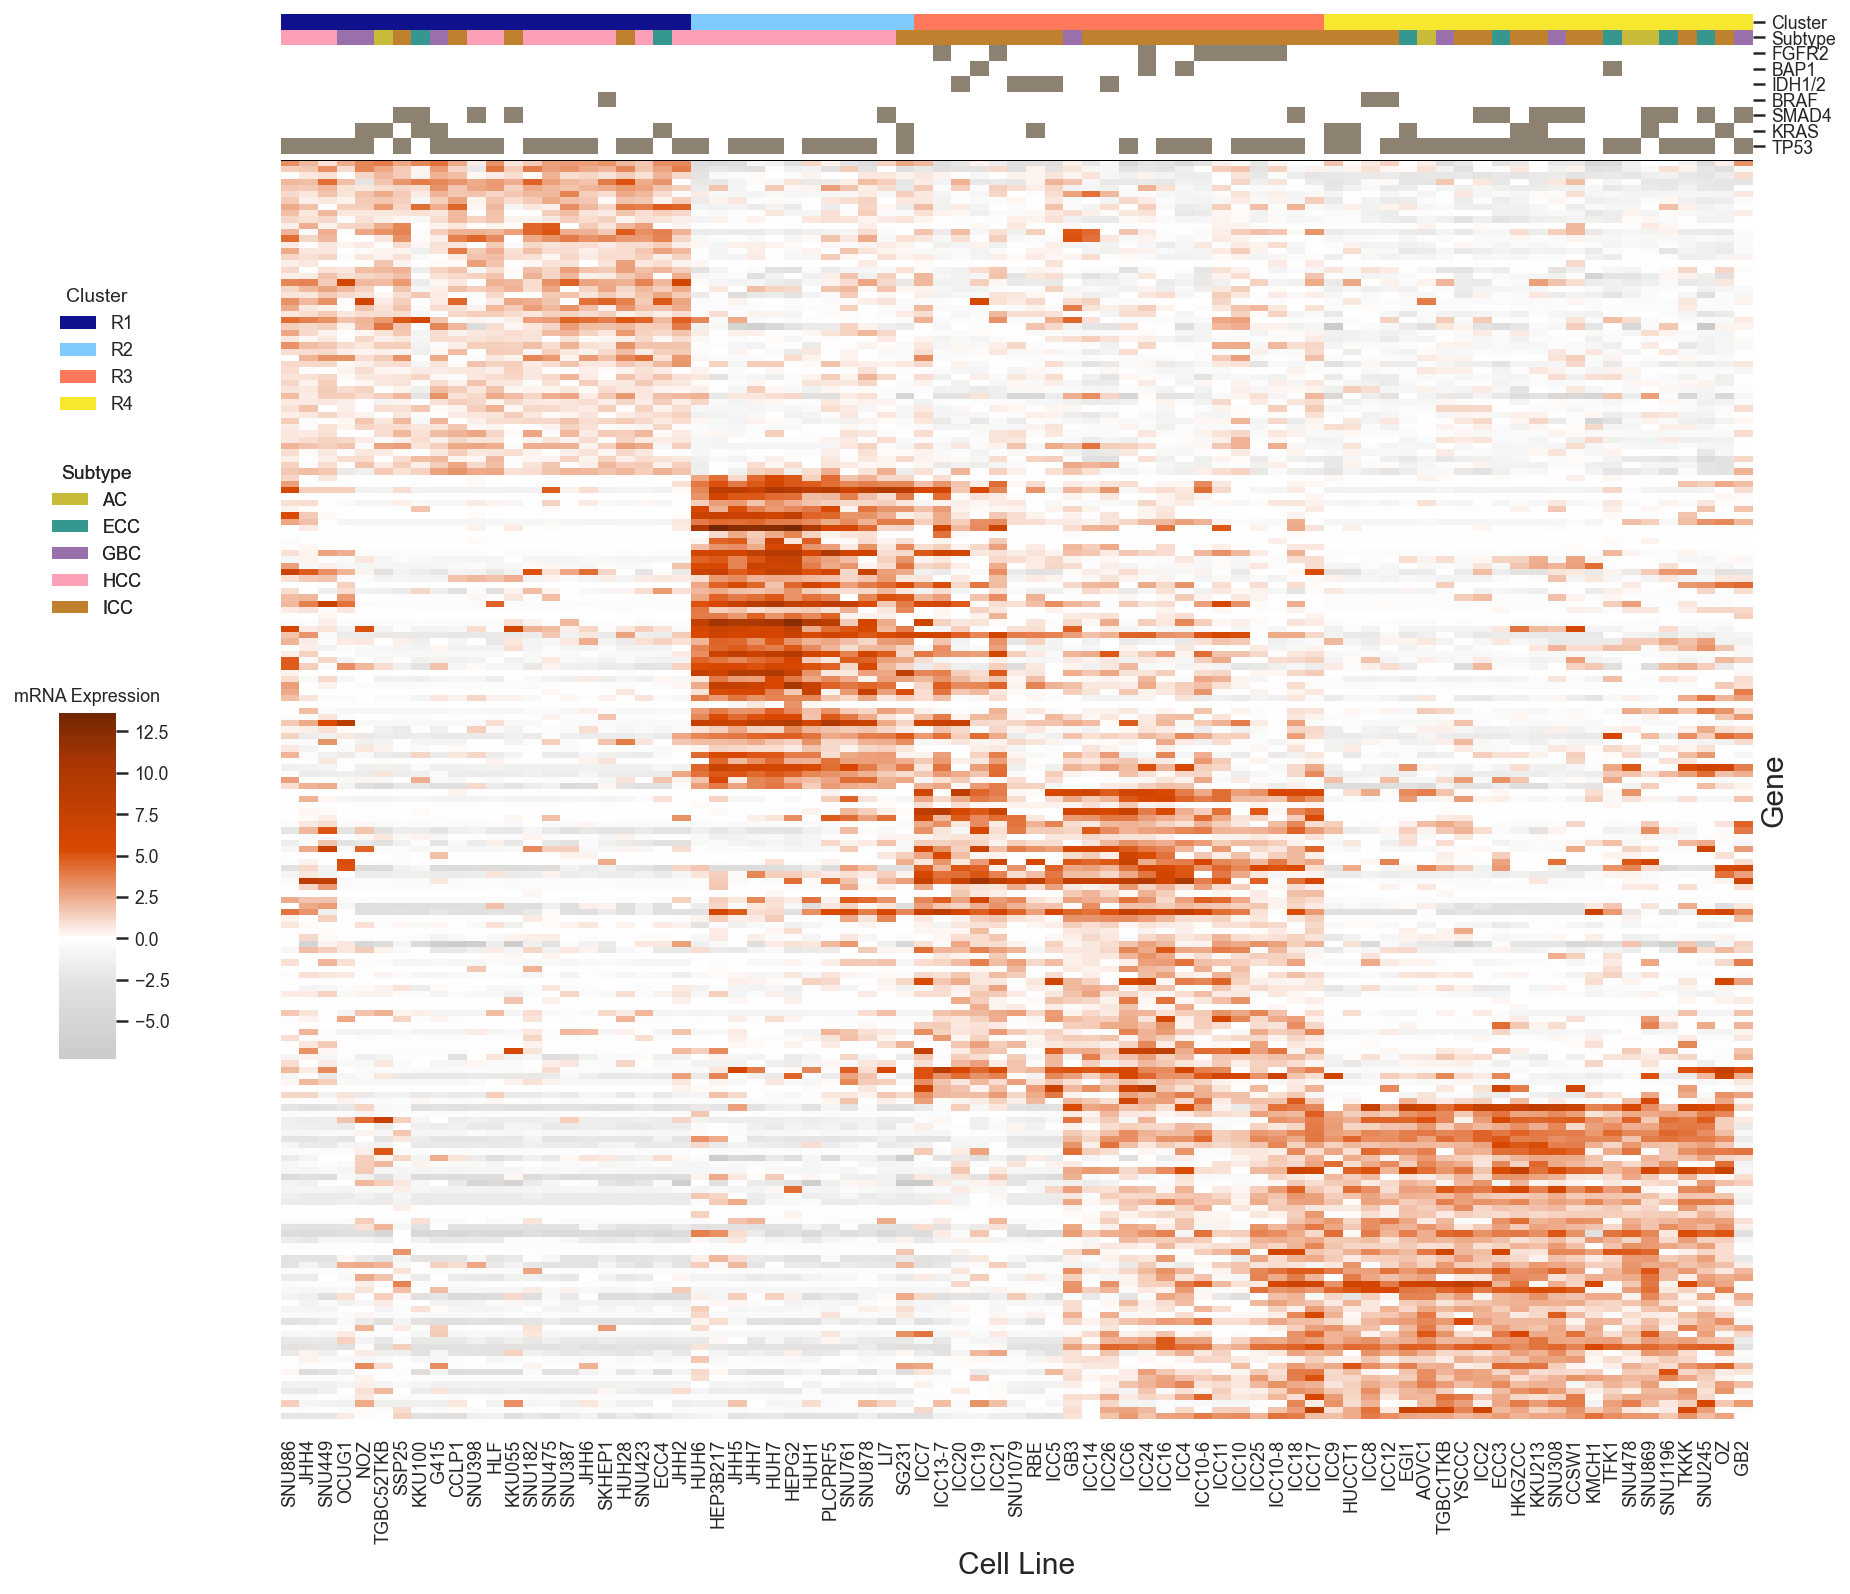

In [8]:
gammas =  [1, 1.5, 2, 2.5, 3, 3.5]
labels_np, consensus_ite = Clustering.louvain_clustering_ensemble(corr_fold_exp_df, gammas=gammas)
# Clustering.plot_consensus_heatmaps(fold_exp_df, corr_fold_exp_df, upset_df, labels_np, consensus_ite)
clusters_reordering = [1, 3, 4, 2] # for visualization
up_markers_df, rna_reordered_upset_df = Clustering.plot_consensus_heatmaps(fold_exp_df, corr_fold_exp_df, upset_df, labels_np, consensus_ite, reverse=False, clusters_reordering=clusters_reordering, feature_cutoff=50, plot_volcano=False, yticklabels=False,  cbar_title=f"mRNA Expression", event_legend = False, event_color='#8D8171',  cbar_left_adjust=0.04, left_adjust=0.07, legend_top_offset=0.7, borders_linewidths=0, clusters_type_filename='RNA_', cluster_prefix='R', save_figure=True)

# Other RNA analysis

## Correlation between clusters

In [9]:
if rna_reordered_upset_df is not None:
    RNA_upset_df = rna_reordered_upset_df.rename(columns={'Cluster':'RNA_Cluster'})
    RNA_upset_df = RNA_upset_df[['RNA_Cluster', 'Subtype']].copy()
else:
    RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
    RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)
RNA_upset_df.shape

(79, 2)

In [10]:
RNA_upset_df['RNA_Cluster'].value_counts()

R4    23
R1    22
R3    22
R2    12
Name: RNA_Cluster, dtype: int64

In [11]:
cur_fold_expr_df = fold_exp_df.dropna()
def get_cluster_df(cluster_name):
    df = cur_fold_expr_df.loc[cur_fold_expr_df.index.isin(RNA_upset_df[RNA_upset_df['RNA_Cluster']==cluster_name].index.tolist())].copy()
    df = df.astype(float)
    return df
df1 = get_cluster_df('R1').T
df2 = get_cluster_df('R2').T
df3 = get_cluster_df('R3').T
df4 = get_cluster_df('R4').T

In [12]:
res_1_2_df = Utils.apply_correlation_dfs(df1,df2)
res_1_3_df = Utils.apply_correlation_dfs(df1,df3)
res_1_4_df = Utils.apply_correlation_dfs(df1,df4)
res_2_3_df = Utils.apply_correlation_dfs(df2,df3)
res_2_4_df = Utils.apply_correlation_dfs(df2,df4)
res_3_4_df = Utils.apply_correlation_dfs(df3,df4)

In [13]:
res_1_2_df.head()

,corr,p-value
"(CCLP1, HEP3B217)",0.050591,1.757315e-11
"(CCLP1, HEPG2)",0.098244,4.149009e-39
"(CCLP1, HUH1)",0.047471,2.797579e-10
"(CCLP1, HUH6)",0.101117,2.450719e-41
"(CCLP1, HUH7)",0.123691,4.019118e-61


In [14]:
res_1_2_df['Group'] = 'R1-R2'
res_1_3_df['Group'] = 'R1-R3'
res_1_4_df['Group'] = 'R1-R4'
res_2_3_df['Group'] = 'R2-R3'
res_2_4_df['Group'] = 'R2-R4'
res_3_4_df['Group'] = 'R3-R4'
res_df = pd.concat([res_1_2_df, res_1_3_df, res_1_4_df, res_2_3_df, res_2_4_df, res_3_4_df], ignore_index=True)

In [15]:
res_df.head()

,corr,p-value,Group
0,0.050591,1.757315e-11,R1-R2
1,0.098244,4.149009e-39,R1-R2
2,0.047471,2.797579e-10,R1-R2
3,0.101117,2.450719e-41,R1-R2
4,0.123691,4.019118e-61,R1-R2


In [16]:
res_1_3_df.shape

(484, 3)

In [17]:
res_2_3_df.shape

(264, 3)

In [18]:
test_res_df = Utils.ranksums_test_all_pairs(res_df, res_df, data_col='corr', cluster_col='Group')
test_res_df


----Pairwise Ranksums test----



,Group_1,Group_2,p-value,q-value,Status
0,R1-R4,R3-R4,1.826600e-50,2.739901e-49,significant
1,R2-R4,R3-R4,4.339683e-35,3.254763e-34,significant
2,R1-R2,R1-R4,3.445315e-34,1.722658e-33,significant
3,R1-R3,R3-R4,8.886451e-28,3.332419e-27,significant
4,R1-R2,R2-R4,2.242861e-26,6.728582e-26,significant
5,R1-R4,R2-R3,5.847261e-24,1.461815e-23,significant
6,R1-R2,R1-R3,9.800105e-20,2.100023e-19,significant
7,R2-R3,R2-R4,1.697588e-17,3.182978e-17,significant
8,R1-R3,R2-R3,1.439284e-10,2.398807e-10,significant
9,R1-R3,R1-R4,6.906314e-06,1.035947e-05,significant


In [19]:
pairs_l = [('R2-R4', 'R3-R4'), ('R1-R3', 'R2-R3'), ('R1-R4', 'R3-R4'), ('R2-R3', 'R2-R4'), ('R1-R2', 'R1-R3')]
qvals = []
for pair in pairs_l:
    qvals.append(test_res_df[(test_res_df['Group_1']==pair[0]) & (test_res_df['Group_2']==pair[1])]['q-value'].values[0])
qvals

[3.2547625962718004e-34,
 2.398807048353498e-10,
 2.739900684963212e-49,
 3.1829776305140146e-17,
 2.1000226010881625e-19]

<Figure size 400x200 with 0 Axes>

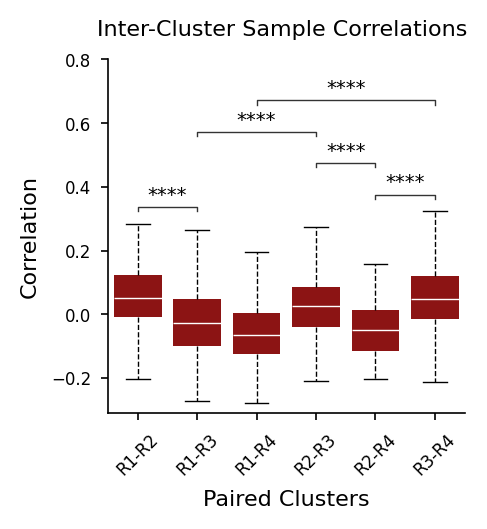

In [20]:
color_dic = {'R1-R2': maroon_color, 'R1-R3': maroon_color, 'R1-R4': maroon_color, 'R2-R3': maroon_color, 'R2-R4': maroon_color, 'R3-R4': maroon_color}
MyVisualization.box_plot(res_df, y_col='corr', x_col='Group', color_dic=color_dic, y_label='Correlation', x_label='Paired Clusters', title='Inter-Cluster Sample Correlations', title_fontsize=8, p_value=qvals, sig_threshold=0.1, adj_pval=True, pvalue_pairs=pairs_l, ylim_top=.8, star_pval=True, title_height=1.02, box_aspect=1.1, tick_rotation=45, figure_width=4, figure_height=2, add_counts=False, filename='RNA')

In [21]:
mean_corr_df = pd.DataFrame(0, index=['R1', 'R2', 'R3', 'R4'], columns=['R1','R2', 'R3', 'R4'])
for i in range(1, 5):
    for j in range(i + 1, 5):
        var_name = f'res_{i}_{j}_df'
        if var_name in globals():
            res = globals()[var_name]
            mean_corr_df.loc[f'R{i}',f'R{j}'] = res['corr'].mean()
            mean_corr_df.loc[f'R{j}',f'R{i}'] = res['corr'].mean()
          
mean_corr_df     

,R1,R2,R3,R4
R1,0.000000,0.052875,-0.025680,-0.052602
R2,0.052875,0.000000,0.027945,-0.045374
R3,-0.025680,0.027945,0.000000,0.053018
R4,-0.052602,-0.045374,0.053018,0.000000


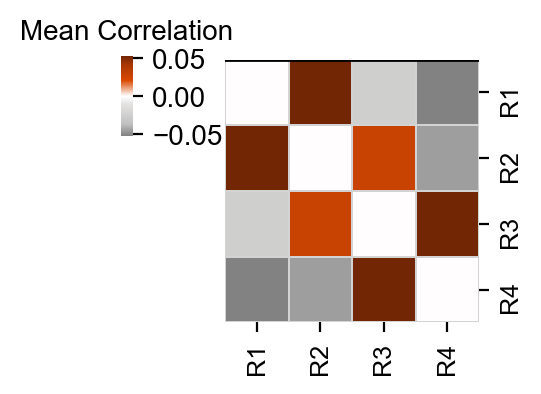

In [22]:
MyVisualization.plot_heatmap(mean_corr_df, row_label='', col_label='', cbar_title='Mean Correlation', cbar_left_adjust=-.09, xtick_fontsize=9, ytick_fontsize=9, title='', figsize_w=2, figsize_h=2, save_figure=True)

## RI RNA Clusters vs Features Clusters
We employ the Adjusted Rand Index (ARI) to assess the concordance between each RNA cluster and various features.

ARI 1: Strong agreement.
ARI around 0: No better than random chance.
ARI -.5: Strong disagreement.

input_data/Additional_Data/Selected_Lists/heatmap_top_alterations.csv  is loaded, shape:  (87, 12)

R1
R2
R3
R4

File  Figure5/output_fig5/adjusted_rand_index_stats_RNA_Clustering.csv saved, shape: (36, 4)

File  Figure5/output_fig5/adjusted_rand_scores_Clustering SimilaritiesRNA_Clustering.csv saved, shape: (36, 4)


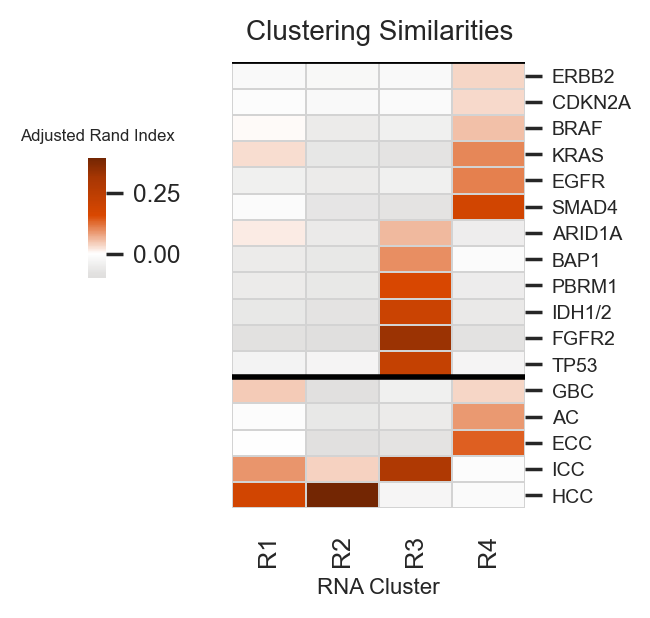

(            R1      R2      R3      R4
 ERBB2      1.0     1.0     1.0  0.2938
 CDKN2A  0.5552     1.0     1.0  0.1066
 BRAF     0.632     1.0     1.0  0.2016
 KRAS    0.3302  0.9202  0.9912  0.0638
 EGFR       1.0     1.0     1.0  0.0248
 SMAD4   0.6502  0.9356   0.996   0.005
 ARID1A  0.4474  0.8824  0.2132  0.9122
 BAP1       1.0     1.0  0.0594   0.759
 PBRM1      1.0     1.0  0.0046     1.0
 IDH1/2     1.0     1.0  0.0014     1.0
 FGFR2      1.0     1.0  0.0002     1.0
 TP53    0.9472  0.8262  0.0006  0.9162
 GBC     0.3032     1.0  0.9086    0.33
 AC        0.74     1.0     1.0  0.0812
 ECC     0.6238     1.0     1.0  0.0178
 ICC     0.0026   0.011  0.0002   0.626
 HCC      0.002  0.0002  0.6756  0.5344,
               R1     R2        R3        R4
 ERBB2        1.0    1.0       1.0       1.0
 CDKN2A       1.0    1.0       1.0  0.568533
 BRAF         1.0    1.0       1.0  0.930327
 KRAS         1.0    1.0       1.0    0.3828
 EGFR         1.0    1.0       1.0    0.1984
 SMAD4   

In [23]:
RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)

top_mut_file = 'Additional_Data/Selected_Lists/heatmap_top_alterations.csv'
top_mut_df = MyLib.load_csv(top_mut_file, index_col=0)
top_mut_df = top_mut_df.rename(columns={c:f'{c}$' for c in top_mut_df.columns.tolist()})
feat_df = top_mut_df.loc[RNA_upset_df.index, ]
feat_df.columns = [c.replace('$', '') for c in feat_df.columns]
feat_df = feat_df.fillna(0)

for f in feat_df.columns:
    feat_df[f] = feat_df[f].apply(lambda x:1 if x!=0 else 0)
for c in RNA_upset_df['Subtype'].unique():
    feat_df[c] = RNA_upset_df['Subtype'].apply(lambda x:1 if x==c else 0)
feats = ["ERBB2", "CDKN2A","BRAF","KRAS","EGFR","SMAD4","ARID1A", "BAP1",  "PBRM1", "IDH1/2", "FGFR2", "TP53", 'GBC', 'AC', 'ECC','ICC','HCC']
feat_df = feat_df[feats]
clusters_df = pd.DataFrame(0, index=RNA_upset_df.index, columns=sorted(RNA_upset_df['RNA_Cluster'].unique()))
for c in clusters_df.columns:
    clusters_df[c] = RNA_upset_df['RNA_Cluster'].apply(lambda x:1 if x==c else 0)
# Clustering.clustering_scores(clusters_df, feat_df, split_row=[12], save_figure=True)
Clustering.clustering_scores_and_statistics(clusters_df, feat_df, split_feats_l=['GBC', 'AC', 'ECC','ICC','HCC'], split_row=[12], filename='RNA_Clustering', save_figure=True)

## Robustness Analysis

### Downsampling (Supplementary Figure 8)

In [24]:
gammas =  [1, 1.5, 2, 2.5, 3, 3.5]
sample_fractions_l = [.80, .75, .70, .65 , .60]
labels_dic = Clustering.run_louvain_on_multiple_subsamples(fold_exp_df, gammas=gammas, sample_fractions_l=sample_fractions_l, filename='RNA')
# labels_dic = MyLib.load_pkl(f'Figure5/output_fig5/RNA_subsampling_labels_dic.pkl')

started 50 runs with fraction 0.8
started 50 runs with fraction 0.75
started 50 runs with fraction 0.7
started 50 runs with fraction 0.65
started 50 runs with fraction 0.6

File  Figure5/output_fig5/RNA_subsampling_labels_dic.pkl saved, data size:  5



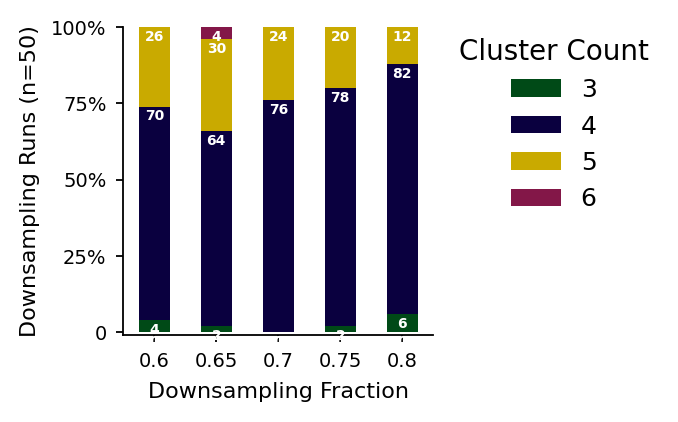

In [25]:
Clustering.louvain_clustering_stability_analysis(labels_dic, filename='RNA_Donwsampling')

<Figure size 400x200 with 0 Axes>

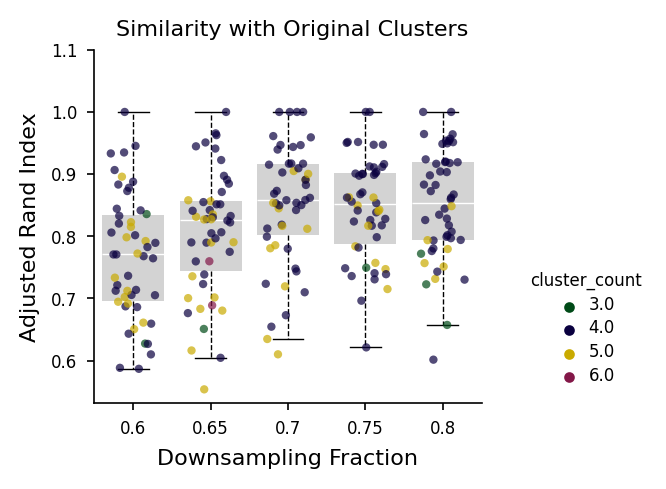

In [26]:
RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)
RNA_cluster_sr = RNA_upset_df['RNA_Cluster']

frac_color_dic = {frac:'lightgray' for frac in sorted(sample_fractions_l)}
Clustering.adjust_rand_index_downsampling_comparisons(RNA_cluster_sr, labels_dic, frac_color_dic, original_cluster_count=4, filename='RNA_Donwsampling')

## Lineage plot

In [27]:
hc_markers_file = 'Additional_Data/Selected_Lists/Hepatocyte Markers.csv'
hc_markers_l = MyLib.load_csv(hc_markers_file, header=None)[0].tolist()
bd_markers_file = 'Additional_Data/Selected_Lists/Bile-duct Markers.csv'
bd_markers_l = MyLib.load_csv(bd_markers_file, header=None)[0].tolist()

input_data/Additional_Data/Selected_Lists/Hepatocyte Markers.csv  is loaded, shape:  (162, 1)

input_data/Additional_Data/Selected_Lists/Bile-duct Markers.csv  is loaded, shape:  (63, 1)



In [28]:
hc_ssgsea_df = MyRFunctions.ssgsea(fold_exp_df.T, hc_markers_l)
hc_ssgsea_df = zscore(hc_ssgsea_df)
hc_ssgsea_df = hc_ssgsea_df.rename(columns={'ssGSEA':'Hepatocyte'})

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [29]:
bd_ssgsea_df = MyRFunctions.ssgsea(fold_exp_df.T, bd_markers_l)
bd_ssgsea_df = zscore(bd_ssgsea_df)
bd_ssgsea_df = bd_ssgsea_df.rename(columns={'ssGSEA':'Bile_duct'})

[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
[1] "Normalizing..."


In [30]:
lineage_ssgsea_upset_df = pd.concat([RNA_upset_df, hc_ssgsea_df, bd_ssgsea_df], axis=1)
MyLib.save_csv(lineage_ssgsea_upset_df, 'ssGSEA_scores_lineage.csv')
lineage_ssgsea_upset_df.head()


File  Figure5/output_fig5/ssGSEA_scores_lineage.csv saved, shape: (79, 4)


,RNA_Cluster,Subtype,Hepatocyte,Bile_duct
SNU886,R1,HCC,0.019967,-0.728369
JHH4,R1,HCC,-0.224520,-0.398487
SNU449,R1,HCC,-0.725670,-0.333010
OCUG1,R1,GBC,-0.269581,-0.149873
NOZ,R1,GBC,-1.210659,-0.389658


<Figure size 500x500 with 0 Axes>

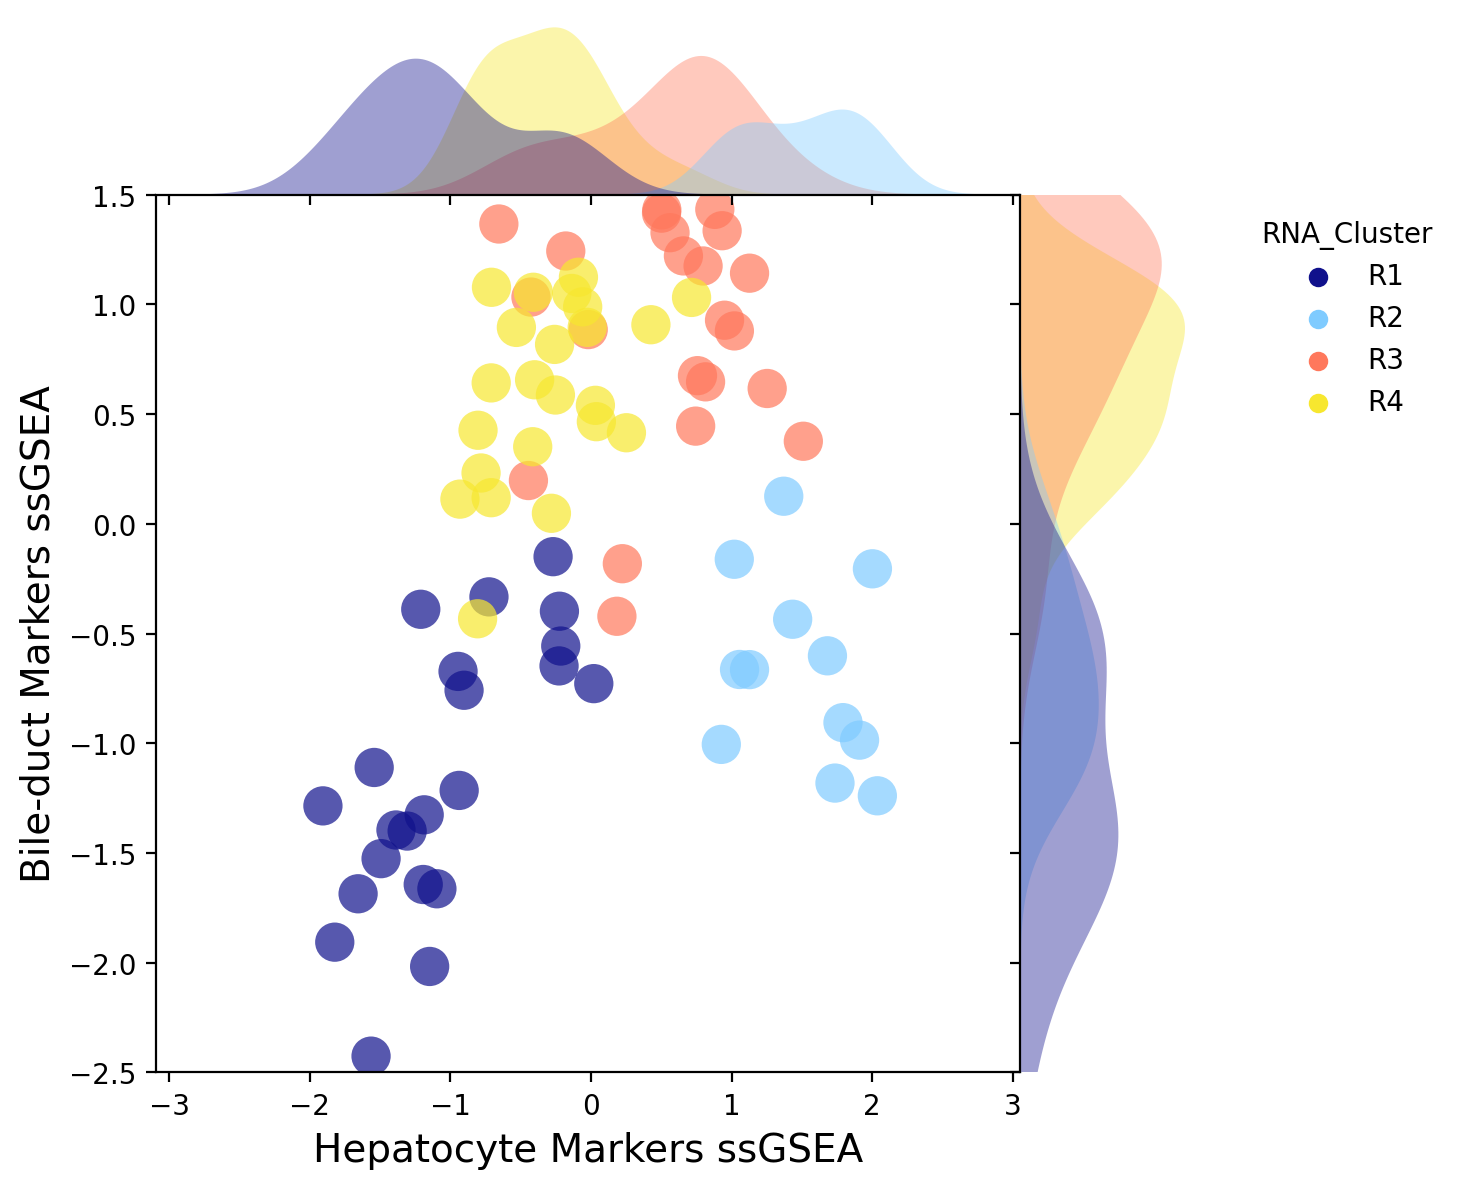

In [31]:
color_dic = MyVisualization.feat_colors_dic['RNA_Cluster']
MyVisualization.jointplot(lineage_ssgsea_upset_df, xcol='Hepatocyte', ycol='Bile_duct', hue_col='RNA_Cluster',  color_dic=color_dic, ylabel='Bile-duct Markers ssGSEA', xlabel='Hepatocyte Markers ssGSEA', #title_height=1.,
                          ylim_top=1.5, ylim_bottom=-2.5,# xlim_left=-2.2, xlim_right=2.5
                          save_figure=True)

# SULT1A1

In [32]:
# RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
# RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)

ICC_RNA_upset_df = RNA_upset_df.loc[RNA_upset_df['Subtype']=='ICC']
ICC_RNA_upset_df = ICC_RNA_upset_df[ICC_RNA_upset_df['RNA_Cluster'].isin(['R3', 'R4'])]

In [33]:
color_dic = {'R3': MyVisualization.feat_colors_dic['RNA_Cluster']['R3'], 'R4':MyVisualization.feat_colors_dic['RNA_Cluster']['R4']}

### mRNA

ranksum p-value=0.010932905952920473
There is a significant association.


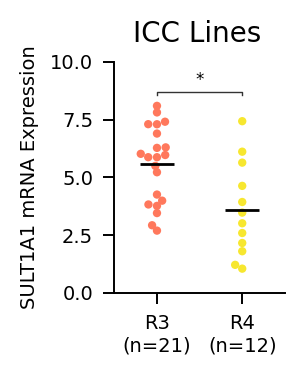

In [34]:
x = 'RNA_Cluster'
gene = 'SULT1A1'
# fold_exp_filtered_df = fold_exp_df.loc[ICC_RNA_upset_df.index, :]
exp_filtered_df = exp_df.loc[ICC_RNA_upset_df.index, :]
df = pd.concat([exp_filtered_df[gene], ICC_RNA_upset_df['RNA_Cluster']], axis=1)
Utils.compare_visualize_cat_features(df, x=x, y=gene, color_dic=color_dic, y_label=f'{gene} mRNA Expression', x_label='', test='ranksum', title='ICC Lines', title_height=1.02, figure_width=1.1, figure_height=1.5, label_fontsize=7,  ylim_top=10, ylim_bottom=0, label_newline=True, save_figure=True)

# HNF1B

In [35]:
RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)

color_dic = MyVisualization.feat_colors_dic['RNA_Cluster']

In [36]:
hnf1b_upset_df = pd.concat([RNA_upset_df, exp_df['HNF1B']], axis=1)
hnf1b_upset_df

,RNA_Cluster,Subtype,HNF1B
SNU886,R1,HCC,3.165108
JHH4,R1,HCC,5.679199
SNU449,R1,HCC,6.206917
OCUG1,R1,GBC,2.500802
NOZ,R1,GBC,0.056584
...,...,...,...
SNU1196,R4,ECC,3.166715
TKKK,R4,ICC,5.614121
SNU245,R4,ECC,2.931683
OZ,R4,ICC,0.000000


In [37]:
res_df = Utils.ranksums_test_all_pairs(hnf1b_upset_df, hnf1b_upset_df, data_col='HNF1B', cluster_col='RNA_Cluster')
res_df


----Pairwise Ranksums test----



,RNA_Cluster_1,RNA_Cluster_2,p-value,q-value,Status
0,R3,R4,0.000003,0.000017,significant
1,R1,R3,0.000027,0.000080,significant
2,R2,R3,0.000178,0.000357,significant
3,R1,R2,0.068775,0.103163,ns
4,R1,R4,0.162592,0.180907,ns
5,R2,R4,0.180907,0.180907,ns


In [38]:
pairs_l = [('R1', 'R2'), ('R1', 'R3'), ('R2', 'R3'), ('R3', 'R4')]
qvals = []
for pair in pairs_l:
    qvals.append(res_df[(res_df['RNA_Cluster_1']==pair[0]) & (res_df['RNA_Cluster_2']==pair[1])]['q-value'].values[0])
qvals

[0.10316279756958902,
 7.951049751107197e-05,
 0.0003566428557231821,
 1.7432881544498882e-05]

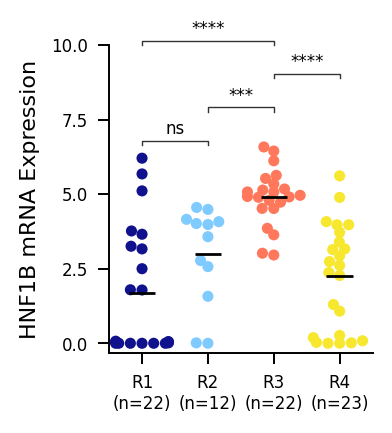

In [39]:
MyVisualization.swarm_plot(hnf1b_upset_df[['HNF1B','RNA_Cluster']], y_col='HNF1B', x_col='RNA_Cluster', hue_col='RNA_Cluster', palette_dic=color_dic, y_label='HNF1B mRNA Expression', x_label='', p_value=qvals, sig_threshold=0.1, adj_pval=True, pvalue_pairs=pairs_l, star_pval=True, title_height=1.02,  ylim_top=10,   labels_fontsize=8, figure_width=1.7, figure_height=2, label_newline=True, save_figure=True)

# Duct Markers

In [40]:
sd_markers_l = ['CDH2', 'CRP', 'NCAM1']
ld_markers_l = ['EPCAM',  'S100P']#'KRT19', 'KRT7',

In [41]:
RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)
btc_upset_df = RNA_upset_df[RNA_upset_df['Subtype']!= 'HCC']
r3_ids_l = btc_upset_df[btc_upset_df['RNA_Cluster']=='R3'].index.tolist()
r4_ids_l = btc_upset_df[btc_upset_df['RNA_Cluster']=='R4'].index.tolist()
btc_rna_df = exp_df.loc[btc_upset_df.index]
r3_rna_df = btc_rna_df.loc[r3_ids_l]
r4_rna_df = btc_rna_df.loc[r4_ids_l]
print(len(r3_ids_l), len(r4_ids_l))

22 23


In [42]:
hue_order = ['R3', 'R4']
palette = {'R3': '#FF785C', 'R4': '#F7E72F'}

## Large duct markers

In [43]:
r3_large_duct_rna_df = r3_rna_df[ld_markers_l]
r3_ld_melt_df = pd.melt(r3_large_duct_rna_df)
r3_ld_melt_df['Group'] = 'R3'

r4_large_duct_rna_df = r4_rna_df[ld_markers_l]
r4_ld_melt_df = pd.melt(r4_large_duct_rna_df)
r4_ld_melt_df['Group'] = 'R4'

In [44]:
ld_df = pd.concat([r3_ld_melt_df, r4_ld_melt_df], axis=0)
pvals_dic = dict()
pvals_dic2 = dict()
for g in ld_markers_l:
    pval = ranksums(r3_large_duct_rna_df[g], r4_large_duct_rna_df[g])[1]
    pvals_dic[(g, hue_order[0]), (g, hue_order[1])]= pval
    pvals_dic2[g] = pval
pairs = pvals_dic.keys()
print('p-values', pvals_dic.values())
adj_pvals = fdrcorrection(list(pvals_dic.values()))[1]
print(pairs)
print(adj_pvals)

p-values dict_values([0.0045365525508797985, 0.00522521975053152])
dict_keys([(('EPCAM', 'R3'), ('EPCAM', 'R4')), (('S100P', 'R3'), ('S100P', 'R4'))])
[0.00522522 0.00522522]


<Figure size 300x450 with 0 Axes>

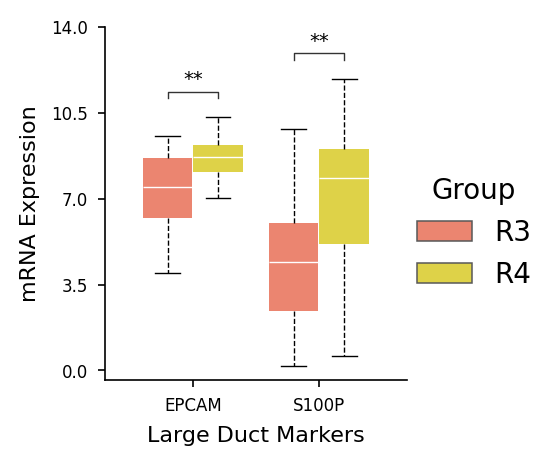

In [45]:
MyVisualization.box_plot(ld_df, x_col='Gene', y_col='value', gp_col='Group', color_dic=palette, order_l=ld_markers_l, star_pval=True, p_value=adj_pvals, adj_pval=True, sig_threshold=0.1, pvalue_pairs=pairs, box_aspect=1., y_label='mRNA Expression', x_label='Large Duct Markers', ylim_top=14, ytick_step=3.5, add_counts=False, figure_width=3, figure_height=4.5, save_figure=False, filename='ld_r3_r4')

## Small duct markers

In [46]:
r3_small_duct_rna_df = r3_rna_df[sd_markers_l]
r3_sd_melt_df = pd.melt(r3_small_duct_rna_df)
r3_sd_melt_df['Group'] = 'R3'

r4_small_duct_rna_df = r4_rna_df[sd_markers_l]
r4_sd_melt_df = pd.melt(r4_small_duct_rna_df)
r4_sd_melt_df['Group'] = 'R4'

In [47]:
sd_df = pd.concat([r3_sd_melt_df, r4_sd_melt_df], axis=0)
pvals_dic = dict()
pvals_dic2 = dict()
for g in sd_markers_l:
    pval = ranksums(r3_small_duct_rna_df[g], r4_small_duct_rna_df[g])[1]
    pvals_dic[(g, hue_order[0]), (g, hue_order[1])]= pval
    pvals_dic2[g] = pval
pairs = pvals_dic.keys()
print('p-values', pvals_dic.values())
adj_pvals = fdrcorrection(list(pvals_dic.values()))[1]
print(pairs)
print(adj_pvals)

p-values dict_values([3.244761518758128e-06, 1.46911896459768e-07, 3.0528679691863325e-07])
dict_keys([(('CDH2', 'R3'), ('CDH2', 'R4')), (('CRP', 'R3'), ('CRP', 'R4')), (('NCAM1', 'R3'), ('NCAM1', 'R4'))])
[3.24476152e-06 4.40735689e-07 4.57930195e-07]


<Figure size 300x450 with 0 Axes>

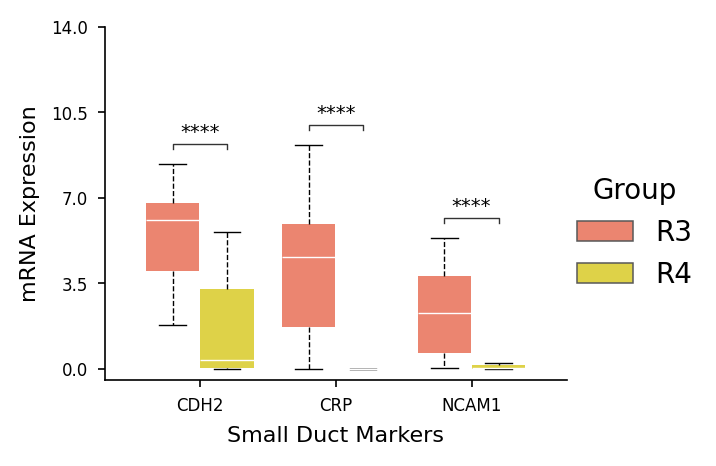

In [48]:
MyVisualization.box_plot(sd_df, x_col='Gene', y_col='value', gp_col='Group', color_dic=palette, order_l=sd_markers_l, star_pval=True, p_value=adj_pvals, adj_pval=True, sig_threshold=0.1, pvalue_pairs=pairs, box_aspect=1.2, y_label='mRNA Expression', x_label='Small Duct Markers', ylim_top=14, ytick_step=3.5, add_counts=False, figure_width=3, figure_height=4.5, save_figure=False, filename='sd_r3_r4')

# Dependency Analysis for Clusters

In [49]:
gene_effect_file = 'Main_Data/CRISPR/CRISPR.csv'
gene_effect_df = MyLib.load_csv(gene_effect_file, index_col=0)
gene_effect_df = gene_effect_df.T.dropna(axis=1)

genes_exclude_file = 'Additional_Data/Selected_Lists/all_common_genes.csv'
genes_exclude = MyLib.load_csv(genes_exclude_file)['Gene'].tolist()
gene_effect_df = gene_effect_df.loc[:, ~gene_effect_df.columns.isin(genes_exclude)]
gene_effect_df = gene_effect_df.rename(columns={c:c.split(' (')[0] for c in gene_effect_df.columns})

input_data/Main_Data/CRISPR/CRISPR.csv  is loaded, shape:  (18443, 60)

input_data/Additional_Data/Selected_Lists/all_common_genes.csv  is loaded, shape:  (2577, 1)



In [50]:
RNA_upset_file = 'Figure5/output_fig5/RNA_Gene_reordered_upset_df.csv'
RNA_upset_df = pd.read_csv(RNA_upset_file, index_col=0)
ICC_RNA_upset_df = RNA_upset_df.loc[RNA_upset_df['Subtype']=='ICC']

In [51]:
fold_exp_df.shape

(79, 17649)

In [52]:
gene_effect_filtered_df, fold_exp_filtered_df = Utils.match_rows_df(gene_effect_df, fold_exp_df)
fold_exp_filtered_df.shape

(58, 17649)

Number of cell lines in each RNA cluster:

In [53]:
RNA_upset_df['RNA_Cluster'].value_counts()

R4    23
R1    22
R3    22
R2    12
Name: RNA_Cluster, dtype: int64

In [54]:
RNA_upset_filtered_df = RNA_upset_df.loc[RNA_upset_df.index.isin(fold_exp_filtered_df.index)]
print(RNA_upset_filtered_df.shape)
print('Number of cell lines in each RNA cluster that have dependency data for each cluster:')
RNA_upset_filtered_df['RNA_Cluster'].value_counts()

(58, 2)
Number of cell lines in each RNA cluster that have dependency data for each cluster:


R4    21
R1    20
R2    10
R3     7
Name: RNA_Cluster, dtype: int64

Unlike C3, most cell lines from C4 have dependency data

## Select Dependency features

Among cell lines with RNA, there are 58 cell lines with CRISPR data

In [55]:
gene_effect_filtered_df.shape

(58, 15308)

1. Select top variable genes

In [56]:
var_df = Clustering.select_top_variable_features(gene_effect_filtered_df, top_k=100)
var_df.shape

(58, 100)

2. Select top LRT scored genes 

In [57]:
lrt_file = 'Additional_Data/Selected_Lists/lrt_table.csv'
lrt_df = MyLib.load_csv(lrt_file)
lrt_df = lrt_df[lrt_df['skewed_left']]
lrt_df.reset_index(inplace=True, drop=True)
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.split('..')[0]+' ('+x.split('..')[1]+')').apply(lambda x:x.replace('.)', ')'))
lrt_df['gene'] = lrt_df['gene'].apply(lambda x:x.replace('.', '-'))
lrt_df['name'] = lrt_df['gene'].apply(lambda x:x.split()[0])
threshold = np.percentile(lrt_df['lrt'].dropna(), 98)

genes_lrt_l = [g for g in lrt_df[lrt_df['lrt']> round(threshold)]['name'].tolist() if g in gene_effect_filtered_df.columns]
gene_effect_lrt_df = gene_effect_filtered_df[genes_lrt_l]
gene_effect_lrt_df.shape

input_data/Additional_Data/Selected_Lists/lrt_table.csv  is loaded, shape:  (18443, 5)



(58, 193)

3. Select top variable hallmark genes

In [58]:
cosmic_file = 'Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv'
cosmic_df = MyLib.load_csv(cosmic_file, index_col=0)

cosmic_df = cosmic_df[cosmic_df['Hallmark'] == 'Yes']
hallmark_l = cosmic_df.index.tolist()
hallmark_l = sorted(set(hallmark_l).intersection(gene_effect_filtered_df.columns.tolist()))
len(hallmark_l)

input_data/Additional_Data/Selected_Lists/cosmic/Census_allFri Dec 22 20_09_34 2023.csv  is loaded, shape:  (743, 19)



291

(291,)


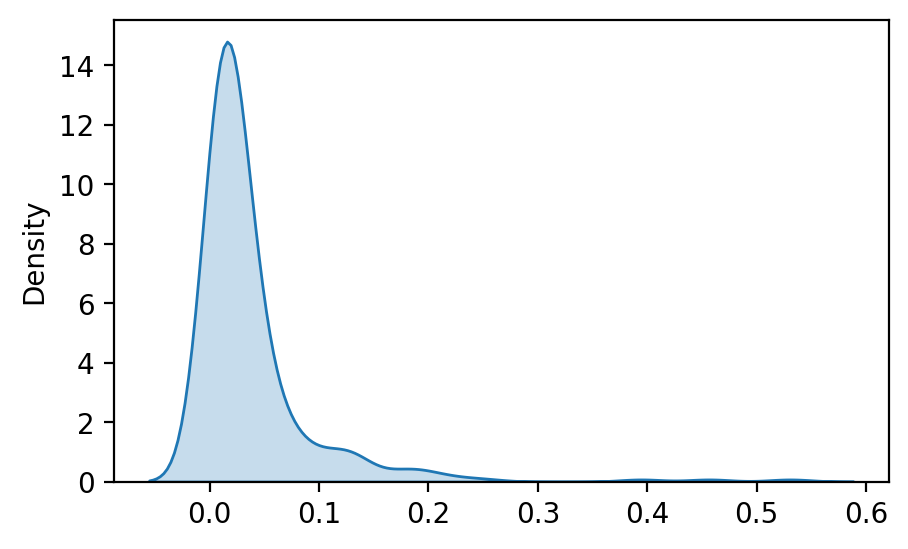

In [59]:
var_sr = gene_effect_filtered_df[hallmark_l].var(axis=0)
print(var_sr.shape)
MyVisualization.plot_distribution(var_sr)

In [60]:
hm_df = Clustering.drop_low_vars(gene_effect_filtered_df[hallmark_l], threshold=0.1)
hm_df.shape

(58, 27)

4. Select preferential genes (top 20 most dependent genes from each cell lines)

In [61]:
pref_file = 'Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv'
pref_l = MyLib.load_csv(pref_file, index_col=0).index.tolist()
pref_l = [g for g in pref_l if g in gene_effect_filtered_df.columns]
len(pref_l)

input_data/Additional_Data/Selected_Lists/BTC_Preferential Dependencies.csv  is loaded, shape:  (696, 1)



620

Take the union of all the selected genes

In [62]:
genes_l = sorted(set(pref_l).union(var_df.columns.tolist()).union(set(hm_df.columns)).union(gene_effect_lrt_df.columns))
gene_effect_filtered_df2 = gene_effect_filtered_df[genes_l].copy()

gene_effect_filtered_df2.shape

(58, 771)

In [63]:
MyLib.save_csv(pd.Series(gene_effect_filtered_df2.columns), 'rna_clusters_DDA_features.csv', index=False)


File  Figure5/output_fig5/rna_clusters_DDA_features.csv saved, shape: (771,)


In [64]:
volcano_axes_lim_dic = {'R1':(4.5,None, 2, -2, .75, None), 'R2':(3,None, 2, -2, None, None), 'R3':(3,None, 2, -2, None, None), 'R4':(6,None, 2, -2, None, None)}

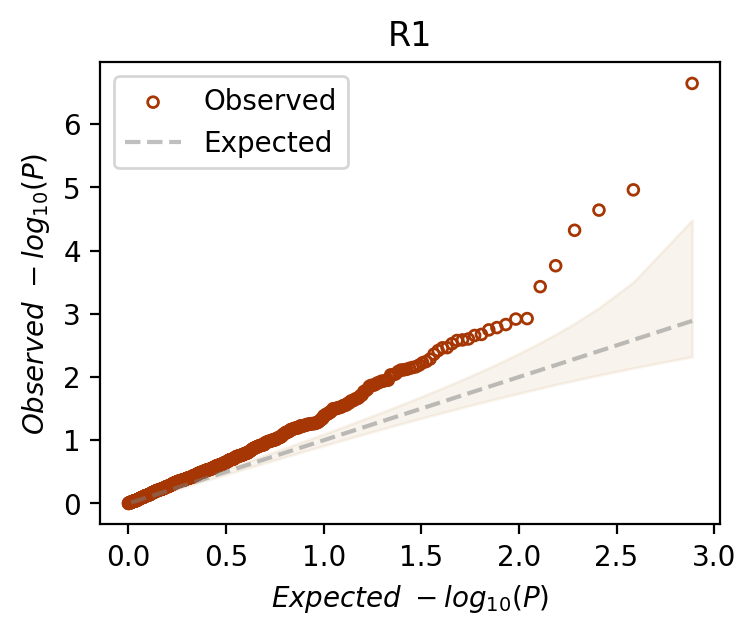


File  Figure5/output_fig5/dependency_hits_all_R1_features_Down.csv saved, shape: (3, 6)


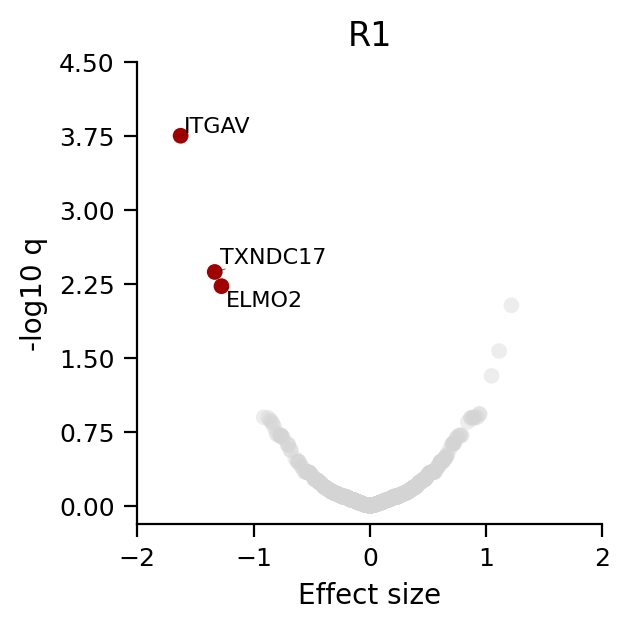


File  Figure5/output_fig5/dependency_hits_R1_features_Down_dep_hits.csv saved, shape: (3, 5)

File  Figure5/output_fig5/dependency_hits_R1_features_Down.csv saved, shape: (3, 5)


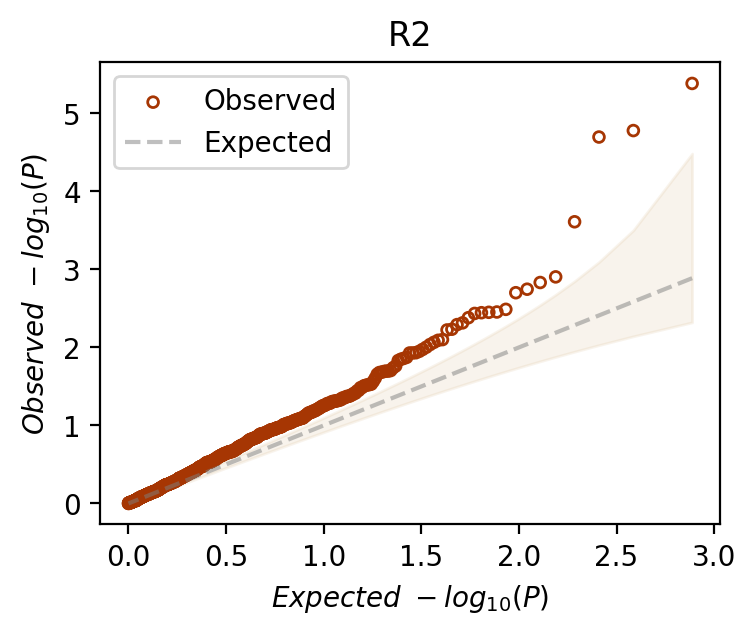


File  Figure5/output_fig5/dependency_hits_all_R2_features_Down.csv saved, shape: (3, 6)


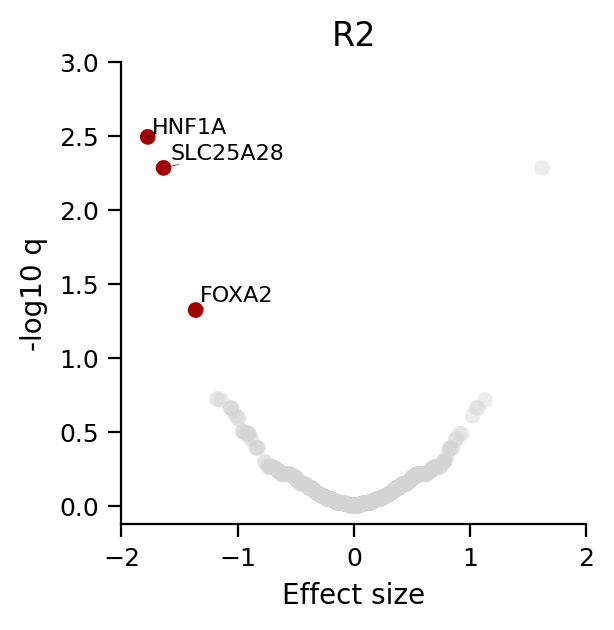


File  Figure5/output_fig5/dependency_hits_R2_features_Down_dep_hits.csv saved, shape: (3, 5)

File  Figure5/output_fig5/dependency_hits_R2_features_Down.csv saved, shape: (3, 5)


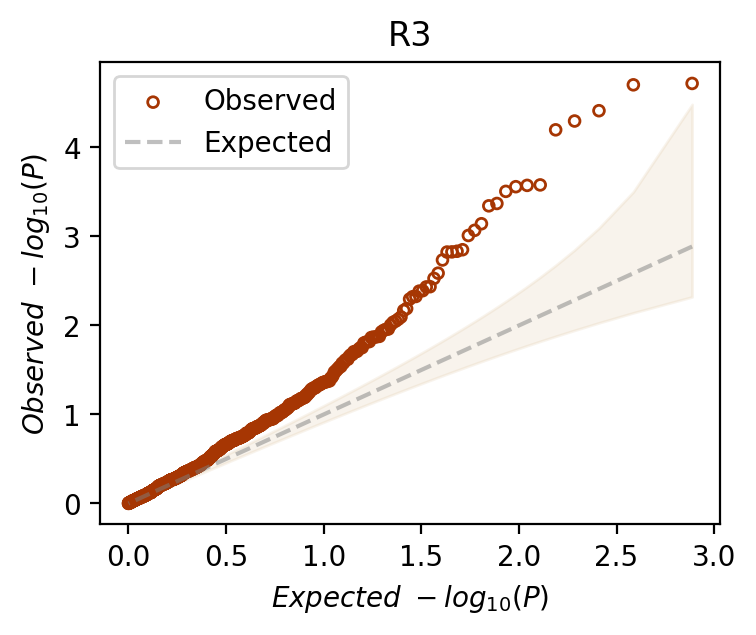


File  Figure5/output_fig5/dependency_hits_all_R3_features_Down.csv saved, shape: (18, 6)


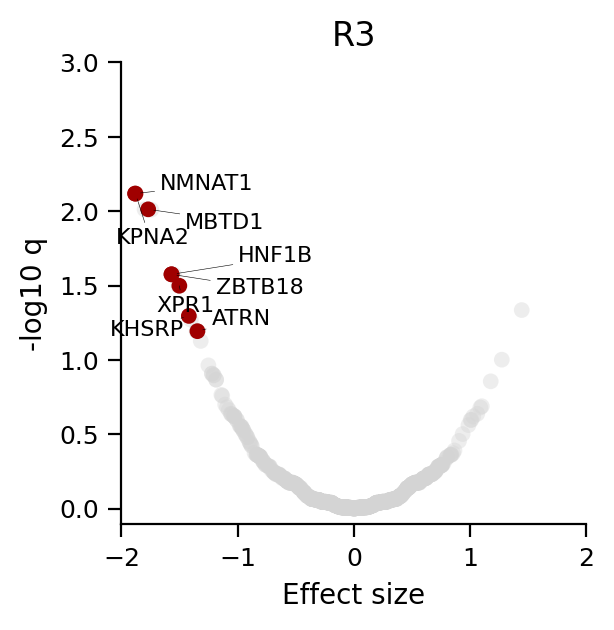


File  Figure5/output_fig5/dependency_hits_R3_features_Down_dep_hits.csv saved, shape: (8, 5)

File  Figure5/output_fig5/dependency_hits_R3_features_Down.csv saved, shape: (18, 5)


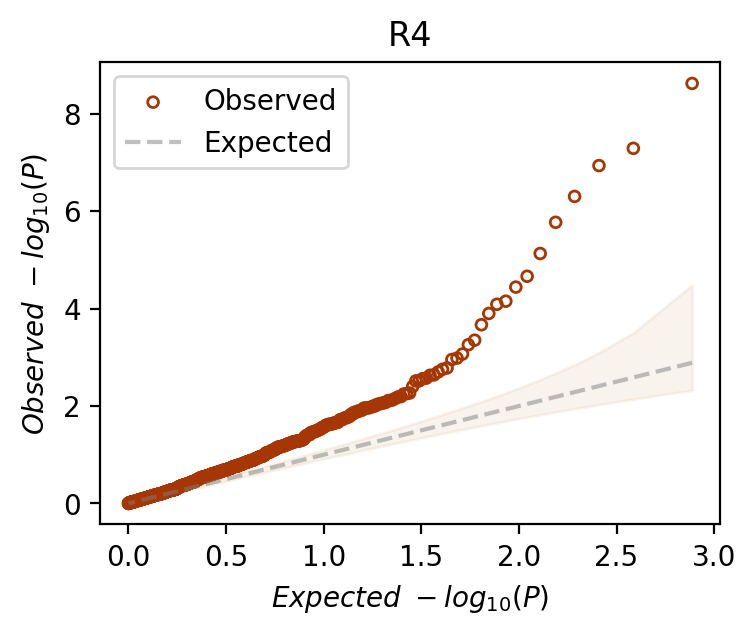


File  Figure5/output_fig5/dependency_hits_all_R4_features_Down.csv saved, shape: (19, 6)


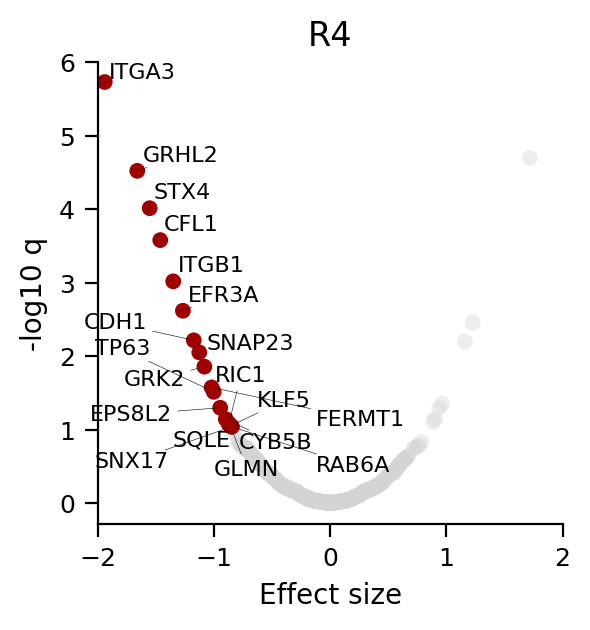


File  Figure5/output_fig5/dependency_hits_R4_features_Down_dep_hits.csv saved, shape: (19, 5)

File  Figure5/output_fig5/dependency_hits_R4_features_Down.csv saved, shape: (19, 5)


In [65]:
# features = Clustering.identify_significant_features(gene_effect_filtered_df2.loc[RNA_upset_filtered_df.index], RNA_upset_filtered_df, up_regulated=False, ttest=True, cluster_column='RNA_Cluster', q_val_thr=0.1, force_points=2.6, force_text=.1, volcano_axes_lim_dic=volcano_axes_lim_dic, save_figure=True, gene_effect_thr=-0.5, cut_off_labels_top=0, add_mean_cols=True, filename_prefix='dependency_hits_')
features = Clustering.identify_significant_features(gene_effect_filtered_df2.loc[RNA_upset_filtered_df.index], RNA_upset_filtered_df, up_regulated=False, ttest=True, cluster_column='RNA_Cluster', q_val_thr=0.1, force_points=2.6, force_text=.1, volcano_axes_lim_dic=volcano_axes_lim_dic, save_figure=True, gene_effect_thr=-0.5, cut_off_labels_top=20, filter=True, add_mean_cols=True, filename_prefix='dependency_hits_')

# GRHL2

In [66]:
btc_upset_df = raw_upset_df[(raw_upset_df['Subtype'] != 'HCC') & (raw_upset_df['CRISPR'] == 1) & (raw_upset_df['RNA'] == 1)]
len(btc_upset_df)

37

In [67]:
btc_rna_df = exp_df.loc[btc_upset_df.index]
btc_ge_df = gene_effect_df.loc[btc_upset_df.index]

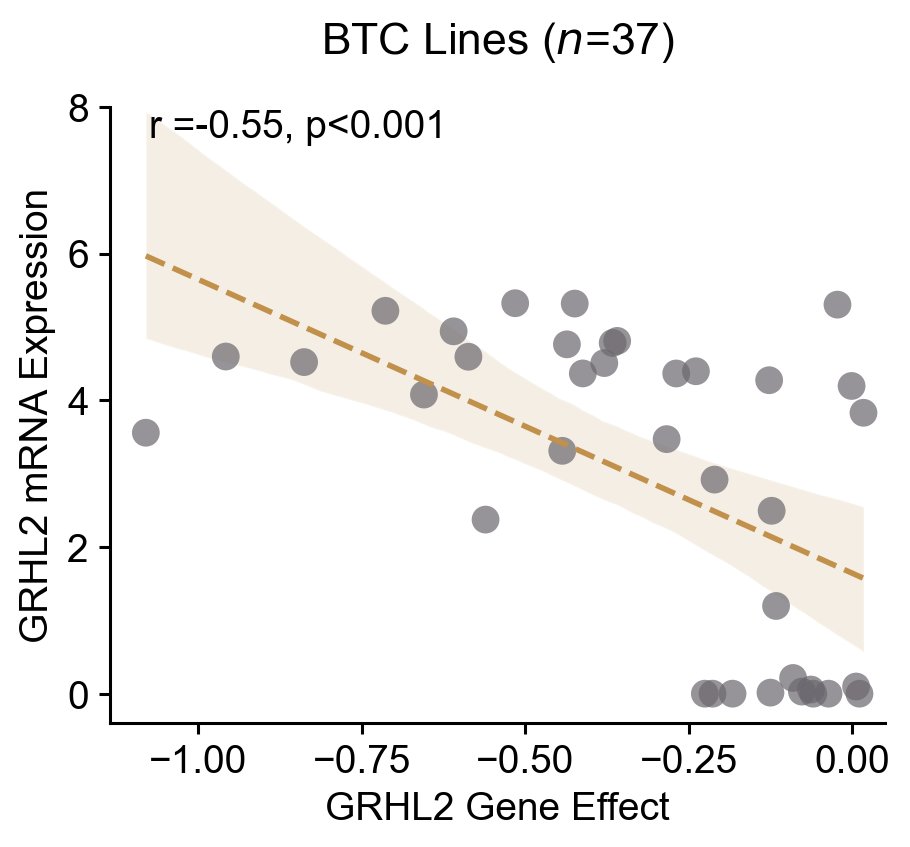

In [68]:
gene = 'GRHL2'
points_color = '#6b676e'
line_color = '#C1914B'
x, y = Utils.match_rows_df(btc_ge_df[[gene]], btc_rna_df[[gene]])
df = pd.concat([x, y], axis=1)
df.columns=['gene_effect', 'mrna']

MyVisualization.reg_plot(data_df=df, x_col='gene_effect', y_col='mrna', title=f'BTC Lines ($n$={df.shape[0]})', points_color_code=points_color, line_color_code=line_color, xlabel=f'{gene} Gene Effect',  ylabel=f'{gene} mRNA Expression', marker='o', title_height=1.06, text_height=.95, ylim_top=8, ytick_step=2,  xlim_right=.05, xtick_step=.25, file_name=f'{gene}_{gene}_rna_ge')